<font size="6"><center>**Compute Targets**</font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

running notebook configuration


In [3]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [4]:
from src.data_api import sources
from src import utils, tags

from src import data_preparation as dataprep 

In [5]:
conf = utils.get_conf()

In [6]:
fparams = conf['func_params']

start_dt = fparams['start_dt']
end_dt = fparams['end_dt']
avol_top = float(fparams['avol_top'])
avol_window = int(fparams['avol_window'])
tau = int(fparams['target']['tau'])

In [7]:
ticker = 'AMZN'

# Load Data

In [8]:
wiki_prices = sources.read_wiki_prices()

In [9]:
pd.concat([wiki_prices.head(2), wiki_prices.tail(2)], axis=0)

,,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,ticker,,,,,,,,,,,,
1999-11-18,A,45.5000,50.0000,40.0000,44.0000,"44,739,900.0000",0.0000,1.0000,31.0420,34.1120,27.2896,30.0186,"44,739,900.0000"
1999-11-19,A,42.9400,43.0000,39.8100,40.3800,"10,897,100.0000",0.0000,1.0000,29.2954,29.3363,27.1600,27.5489,"10,897,100.0000"
2018-03-26,ZUMZ,23.7500,24.8000,23.7000,24.6500,"375,320.0000",0.0000,1.0000,23.7500,24.8000,23.7000,24.6500,"375,320.0000"
2018-03-27,ZUMZ,24.6500,24.6500,23.3500,23.6000,"403,884.0000",0.0000,1.0000,24.6500,24.6500,23.3500,23.6000,"403,884.0000"


In [10]:
wiki_prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, (Timestamp('1999-11-18 00:00:00'), 'A') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Columns: 12 entries, open to adj_volume
dtypes: float64(12)
memory usage: 1.4+ GB


# Data Preparation

In [11]:
avol = wiki_prices.groupby(tags.TICKER)[tags.VOLUME].transform(lambda grp: grp.rolling(30).mean())

In [12]:
n_tickers = wiki_prices.reset_index(tags.TICKER).groupby(tags.DATE).size()

## Pipeline

```python
def log_returns(prices: pd.Series, tau: int) -> pd.Series:
    """
    Compute log returns on time series data
    log(p2/p1) = log(p2) - log(p1)
    @param prices: time series data
    @param tau: differencing period
    @return: returns
    """


def pl_targets(data: pd.DataFrame, tau_fwd: int) -> pd.DataFrame:
    """
    Target computation on close price
    @param data: input
    @param tau_fwd: target time horizon (forward)
    @return: output
    """
    
def pl_min_avol_filter(data: pd.DataFrame, window: int, qthreshold: float) -> pd.DataFrame:
    """
    Compute rolling Average Volume by ticker and filter top quantile
    @param data: input
    @param window: number o periods to compute rolling mean
    @param qthreshold: filter threshold (top quantile)
    @return: output
    """
    
def pl_date_filter(data: pd.DataFrame, start_dt: str, end_dt: str) -> pd.DataFrame:
    """
    Apply a filter to index level `date`
    @param data: input
    @param start_dt: Filter start
    @param end_dt: Filter end
    @return: output
    """
```

In [13]:
min_yr = '2013'  # must be below start_dt (consdering feature windows)
select_cols = ['adj_open','adj_high','adj_low', 'adj_close', 'adj_volume']

mask_min_yr = wiki_prices.index.get_level_values(tags.DATE)>=pd.Timestamp(min_yr)

feats_and_targets = (wiki_prices
                     .loc[mask_min_yr, select_cols]
                     .pipe(dataprep.pl_targets, tau_fwd=tau)
                     .pipe(dataprep.pl_targets, tau_fwd=1)
                     #.pipe(dataprep.pl_features)
                     .pipe(dataprep.pl_min_avol_filter, window=avol_window, top_n=avol_top)
                     .pipe(dataprep.pl_date_filter, start_dt=start_dt, end_dt=end_dt)
                     .filter(regex=('x_|y_'))
                    )

In [14]:
pd.concat([feats_and_targets.head(2), feats_and_targets.tail(2)], axis=0)

,,y_fwd_logrets_5d,y_fwd_logrets_1d
date,ticker,,
2015-01-02,A,0.0007,-0.0189
2015-01-05,A,0.0078,-0.0157
2017-12-28,ZTS,0.0133,-0.0048
2017-12-29,ZTS,0.0301,-0.0038


In [15]:
singl_stock = feats_and_targets.xs(level=tags.TICKER, key=ticker)
singl_stock_prices = wiki_prices.xs(level=tags.TICKER, key=ticker)

# Visualization

## Trading Population (Universe)

In [ ]:
n_tickers['2016'].plot()
plt.title("Numer of tickers in population by date")
plt.show()

In [ ]:
feats_and_targets.groupby(tags.DATE).size().plot()
plt.title("Numer of tickers in sample by date")
plt.show()

In [ ]:
wiki_prices[tags.VOLUME].describe()

In [ ]:
wiki_prices[tags.VOLUME].clip(upper=1e6).plot.hist(density=True)
plt.axvline(x=7.5e5, color='black', linewidth=1.5)
plt.title("Average Dollar Volume Distribution (clipped)")
plt.show()

## Single stock Visulalizations

In [20]:
#feats_and_targets.index.get_level_values('ticker').unique().tolist()

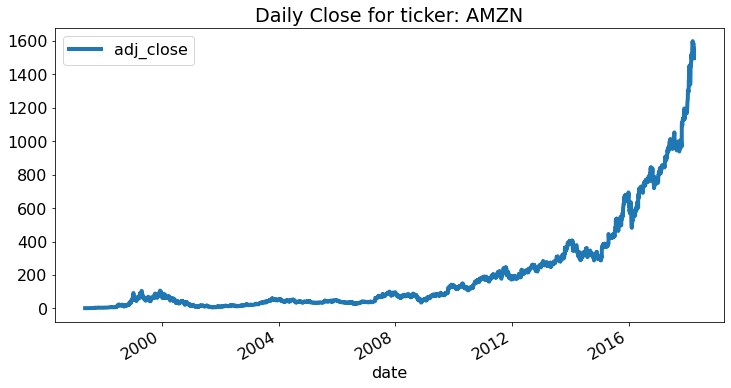

In [21]:
singl_stock_prices.plot(y=tags.CLOSE)
plt.title(f'Daily Close for ticker: {ticker}')
plt.show()

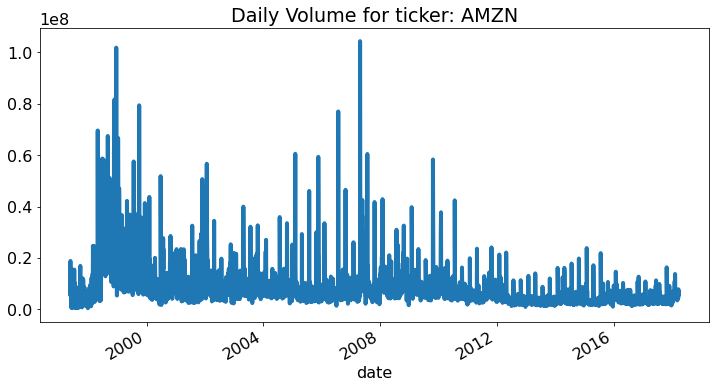

In [22]:
ax = singl_stock_prices[tags.VOLUME].plot()
plt.title(f'Daily Volume for ticker: {ticker}')

plt.show()

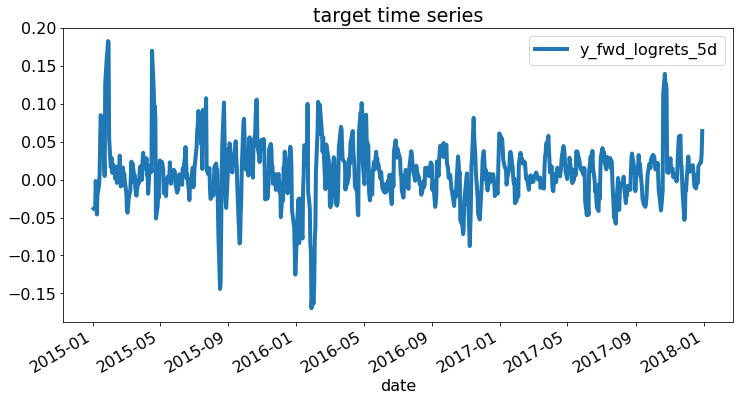

In [23]:
singl_stock.plot(y=tags.TARGET)
plt.title('target time series')
plt.show()

## Stationarity

In [24]:
adfuller(singl_stock_prices[tags.CLOSE])

(5.117608167810011,
 1.0,
 33,
 5214,
 {'1%': -3.4316047990661946,
  '5%': -2.862094490509652,
  '10%': -2.5670651551096757},
 33474.15200559588)

In [25]:
adfuller(singl_stock[tags.TARGET])

(-5.0041853666077225,
 2.1773736680752424e-05,
 20,
 732,
 {'1%': -3.439314999916068,
  '5%': -2.8654965012008677,
  '10%': -2.5688768817372867},
 -3731.944938399378)

## Descriptive Statistics

In [26]:
singl_stock[tags.TARGET].describe()

count   753.0000
mean      0.0093
std       0.0394
min      -0.1696
25%      -0.0106
50%       0.0090
75%       0.0274
max       0.1825
Name: y_fwd_logrets_5d, dtype: float64

In [27]:
singl_stock_roll20 = singl_stock.rolling(20)

singl_stock = singl_stock.assign(
    returns_5d_mave20=singl_stock_roll20[tags.TARGET].std(),
    returns_5d_mstd20=singl_stock_roll20[tags.TARGET].mean())

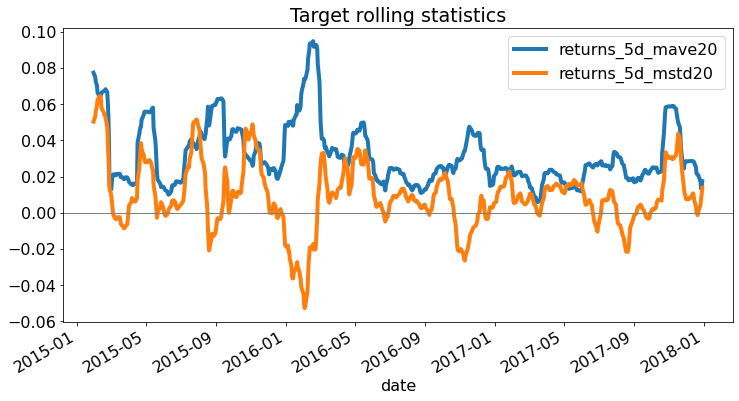

In [28]:
singl_stock.plot(y=['returns_5d_mave20', 'returns_5d_mstd20'])
plt.axhline(y=0, linewidth=1, color='grey')
plt.title("Target rolling statistics")
plt.show()

## ACF and PACF

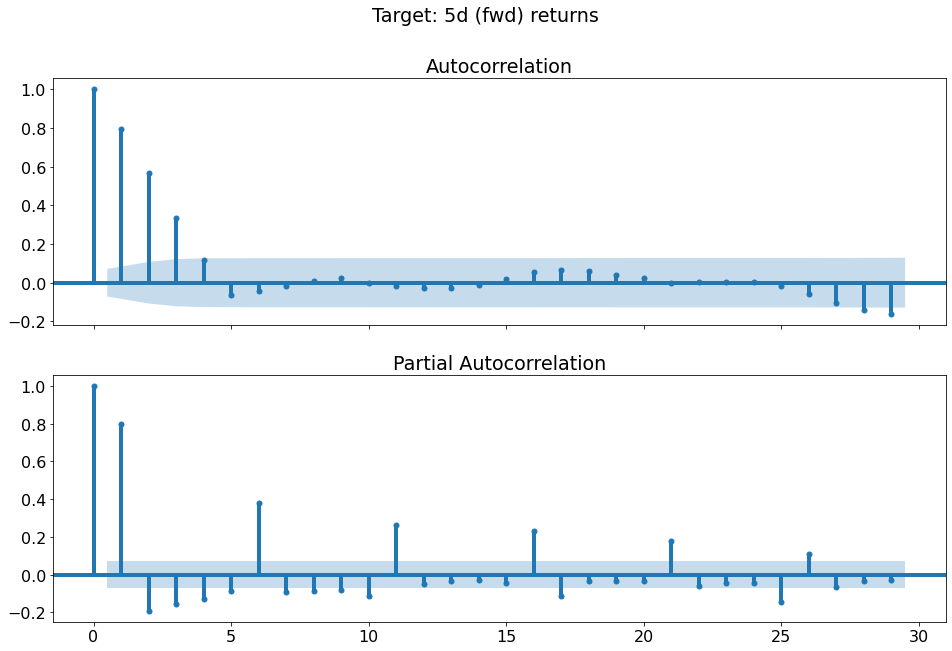

In [29]:
fig, axs = plt.subplots(2,1, figsize=(16,10), sharex=True)

ax = axs[0]
plot_acf(singl_stock[tags.TARGET], ax=ax)

ax = axs[1]
plot_pacf(singl_stock[tags.TARGET], ax=ax)

plt.suptitle("Target: 5d (fwd) returns")

plt.show()

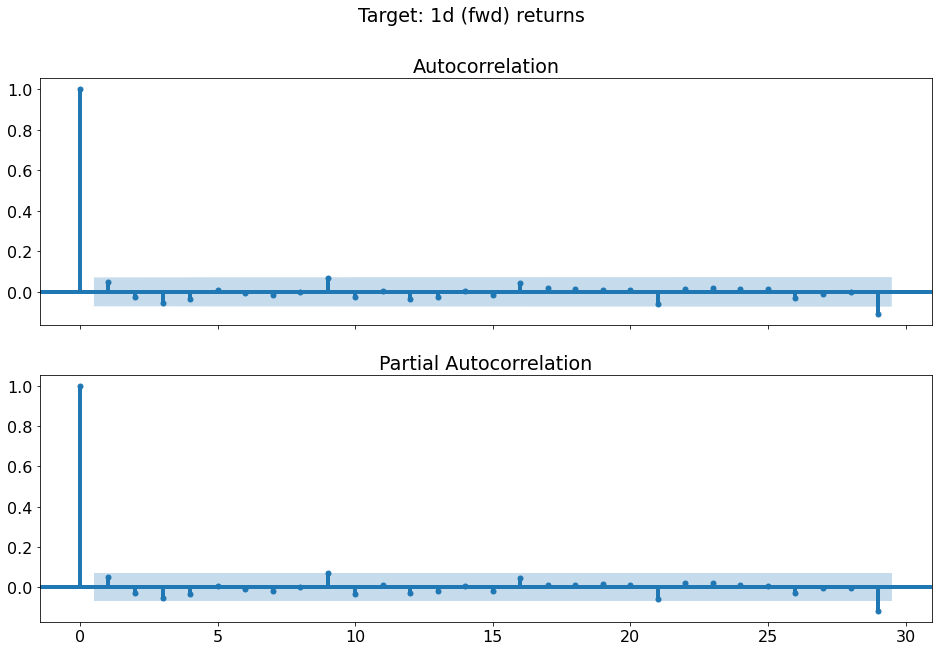

In [30]:
fig, axs = plt.subplots(2,1, figsize=(16,10), sharex=True)

ax = axs[0]
plot_acf(singl_stock['y_fwd_logrets_1d'], ax=ax)

ax = axs[1]
plot_pacf(singl_stock['y_fwd_logrets_1d'], ax=ax)

plt.suptitle("Target: 1d (fwd) returns")
plt.show()